The purpose of this notebook is to create example json files (similar to however a backend API would be serving data) to create a prototype dashboard of the next version of the IMPACTS dashboard.

In [4]:
import pathlib
import glob
import os

import argparse
import geojson
import pandas as pd
import json
import random

from datetime import datetime, timedelta

In [13]:
# Helper array for day indexing
aggregateMonths = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
nsims = 10000

## Generate data for the quantile table

#json_form...

[{
    Location: 'National',
    Type: 'National',
    Current: {
        tornadoes: {
            10: 5,
            50: 9,
            90: 14
        },
        population: {
            10: 100,
            50: 435,
            90: 1340
        },
        ...
    },
    Climo: {
        tornadoes: {
            10: 3,
            50: 5,
            90: 10
        },
        population: {
            10: 50,
            50: 325,
            90: 900
        },
        ...
    }
},
{
    Location: state1,
    Type: 'State',
    Current: {},
    Climo: {}
}
,
{
    Location: state2,
    Type: 'State',
    Current: {},
    Climo: {}
},
{
    Location: cwa1,
    Type: 'CWA',
    Current: {},
    Climo: {}
}
,
{
    Location: cwa2,
    Type: 'CWA',
    Current: {},
    Climo: {}
},
{
    Location: fema1,
    Type: 'FEMA',
    Current: {},
    Climo: {}
}
,
{
    Location: fema2,
    Type: 'FEMA',
    Current: {},
    Climo: {}
}]

In [10]:
jsonResponse = []

In [11]:
# Function to count tornadoes in each simulation
def torCounter(df,filled_df):
    # Use arbitrary column to get count of entries for each sim (i.e., count of tornadoes)
    torsBySim = df.groupby("sim").count().loc[:,'wfos']
    
    # Merge this count with the original 
    merged = filled_df.merge(torsBySim,how='left',on='sim')
    merged.fillna(value=0,inplace=True)
    merged.rename(columns={'wfos':'tornadoes'},inplace=True)
    return merged

In [6]:
# Read in example psv
file = '../data/output/examples/20210428124600_schools_fema.psv.gz'
df = pd.read_csv(file, sep="|")

<AxesSubplot:>

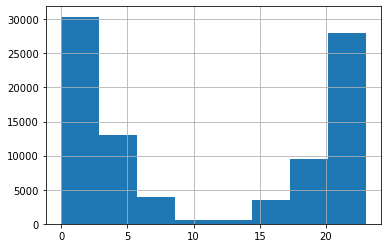

In [9]:
df['time'].hist(bins=8)

In [14]:
sims = df.groupby("sim")
fields = sims.sum().loc[:,('population','hospitals','schools','mobilehomes','psubstations')]

# Fill missing sims with 0s (artifact of how pas writes out files)
fill_fields = fields.reindex(list(range(1,nsims+1)),fill_value=0)

In [15]:
# Get tornado counts
merged = torCounter(df,fill_fields)

In [16]:
quants = merged.quantile(q=[0.1,0.5,0.9],interpolation='nearest')
quants

,population,hospitals,schools,mobilehomes,psubstations,tornadoes
0.1,240,0,0,0,0,2.0
0.5,4640,0,3,0,1,6.0
0.9,46432,2,20,250,8,18.0


In [17]:
nationalResponse = {
    'Location': 'National',
    'Type': 'National',
    'Current': {},
    'Climo': {}
}

for name in quants.columns:
    
    nationalResponse['Current'][name] = {}
    nationalResponse['Climo'][name] = {}
    
    for quant in quants.index:
        
        nationalResponse['Current'][name][quant] = int(quants.loc[quant,name])
        # Just generate random numbers for climo until we have the necessary numbers
        nationalResponse['Climo'][name][quant] = random.random()*10

In [18]:
jsonResponse.append(nationalResponse)

### FEMA

In [7]:
femaBrokenOut = df.assign(category=df['fema'].str.split(',')).explode('category').reset_index(drop=True)

# Remove row if state is NaN
femaBrokenOut = femaBrokenOut[femaBrokenOut['category'].notna()]

# Grab a list of the unique states in the simulation
femaImpacted = femaBrokenOut['category'].unique().tolist()

In [20]:
for fema in femaImpacted:
    
    femaResponse = {
        'Location': fema,
        'Type': 'FEMA',
        'Current': {},
        'Climo': {}
    }
    
    ind_fema = femaBrokenOut[femaBrokenOut['category'] == fema]
    #print(f'State: {state}')
    ind_fema_group = ind_fema.groupby("sim").sum().loc[:,['population','hospitals','schools','mobilehomes','psubstations']]
    ind_fema_tot = ind_fema_group.reindex(list(range(1,10001)),fill_value=0)
    
    # Get tor counts for each state
    ind_fema_tot = torCounter(ind_fema,ind_fema_tot)
    
    fema_quants = ind_fema_tot.quantile(q=[0.1,0.5,0.9],interpolation='nearest')
    
    for name in fema_quants.columns:
    
        femaResponse['Current'][name] = {}
        femaResponse['Climo'][name] = {}

        for quant in fema_quants.index:

            femaResponse['Current'][name][quant] = int(fema_quants.loc[quant,name])
            # Just generate random numbers for climo until we have the necessary numbers
            femaResponse['Climo'][name][quant] = random.random()*10
            
    jsonResponse.append(femaResponse)

### States

In [22]:
stBrokenOut = df.assign(category=df['states'].str.split(',')).explode('category').reset_index(drop=True)

# Remove row if state is NaN
stBrokenOut = stBrokenOut[stBrokenOut['category'].notna()]

# Grab a list of the unique states in the simulation
statesImpacted = stBrokenOut['category'].unique().tolist()

In [23]:
for state in statesImpacted:
    
    stateResponse = {
        'Location': state,
        'Type': 'State',
        'Current': {},
        'Climo': {}
    }
    
    ind_state = stBrokenOut[stBrokenOut['category'] == state]
    #print(f'State: {state}')
    ind_state_group = ind_state.groupby("sim").sum().loc[:,['population','hospitals','schools','mobilehomes','psubstations']]
    ind_state_tot = ind_state_group.reindex(list(range(1,10001)),fill_value=0)
    
    # Get tor counts for each state
    ind_state_tot = torCounter(ind_state,ind_state_tot)
    
    st_quants = ind_state_tot.quantile(q=[0.1,0.5,0.9],interpolation='nearest')
    
    for name in st_quants.columns:
    
        stateResponse['Current'][name] = {}
        stateResponse['Climo'][name] = {}

        for quant in st_quants.index:

            stateResponse['Current'][name][quant] = int(st_quants.loc[quant,name])
            # Just generate random numbers for climo until we have the necessary numbers
            stateResponse['Climo'][name][quant] = random.random()*10
            
    jsonResponse.append(stateResponse)

### CWAs

In [24]:
cwaBrokenOut = df.assign(category=df['wfos'].str.split(',')).explode('category').reset_index(drop=True)

# Remove row if state is NaN
cwaBrokenOut = cwaBrokenOut[cwaBrokenOut['category'].notna()]

# Grab a list of the unique states in the simulation
cwasImpacted = cwaBrokenOut['category'].unique().tolist()

In [25]:
for cwa in cwasImpacted:
    
    cwaResponse = {
        'Location': cwa,
        'Type': 'CWA',
        'Current': {},
        'Climo': {}
    }
    
    ind_cwa = cwaBrokenOut[cwaBrokenOut['category'] == cwa]
    ind_cwa_group = ind_cwa.groupby("sim").sum().loc[:,['population','hospitals','schools','mobilehomes','psubstations']]
    ind_cwa_tot = ind_cwa_group.reindex(list(range(1,10001)),fill_value=0)
    
    # Get tor counts for each state
    ind_cwa_tot = torCounter(ind_cwa,ind_cwa_tot)
    
    cwa_quants = ind_cwa_tot.quantile(q=[0.1,0.5,0.9],interpolation='nearest')
    
    for name in cwa_quants.columns:
    
        cwaResponse['Current'][name] = {}
        cwaResponse['Climo'][name] = {}

        for quant in cwa_quants.index:

            cwaResponse['Current'][name][quant] = int(cwa_quants.loc[quant,name])
            # Just generate random numbers for climo until we have the necessary numbers
            cwaResponse['Climo'][name][quant] = random.random()*10
            
    jsonResponse.append(cwaResponse)

In [26]:
with open('../data/output/examples/jsonResponse_schoolsfema.json','w') as fp:
    json.dump(jsonResponse, fp)

In [28]:
jsonResponse[0]

{'Location': 'National',
 'Type': 'National',
 'Current': {'population': {0.1: 240, 0.5: 4640, 0.9: 46432},
  'hospitals': {0.1: 0, 0.5: 0, 0.9: 2},
  'schools': {0.1: 0, 0.5: 3, 0.9: 20},
  'mobilehomes': {0.1: 0, 0.5: 0, 0.9: 250},
  'psubstations': {0.1: 0, 0.5: 1, 0.9: 8},
  'tornadoes': {0.1: 2, 0.5: 6, 0.9: 18}},
 'Climo': {'population': {0.1: 3.47032136393441,
   0.5: 5.988942965623777,
   0.9: 6.60761784689729},
  'hospitals': {0.1: 4.517491968683695,
   0.5: 3.8528047527110667,
   0.9: 8.15961085171249},
  'schools': {0.1: 2.825898861088705,
   0.5: 2.6808972927475248,
   0.9: 7.245739844816664},
  'mobilehomes': {0.1: 4.036356937986704,
   0.5: 1.1997344187423342,
   0.9: 7.154713682688509},
  'psubstations': {0.1: 9.42134997575721,
   0.5: 3.4262464312732166,
   0.9: 5.849591234256546},
  'tornadoes': {0.1: 5.665011693715366,
   0.5: 6.193443808730269,
   0.9: 3.5326665590584785}}}